In [58]:
import pandas as pd
import numpy as np
import re
import string
import stopwords
import spacy
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

In [29]:
# load text-data and labels
df = pd.read_json("testset.json")
df = df[["transcript", "gattung"]].copy()
df["gattung"] = df["gattung"].apply(lambda x: ' '.join(x))
df

,transcript,gattung
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage
...,...,...
1356,"Da hüpft ein kleines Roboterbein im Kreis, es ...",Bericht
1357,Noch ziemlich entspannt muss ich sagen ich kan...,Bericht
1358,"Seit der hier für die Rabattaktion Nein, bishe...",Bericht
1359,"Ich bin Leon Schäfer, 27 Jahre alt, Paar, Leic...",Bericht


In [16]:
# load embeddings
embeddings = pd.read_json("embeddings.json")
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.015334,0.021697,-0.074221,0.018726,0.054224,0.003047,-0.045695,-0.042731,0.031384,-0.034351,...,0.001353,0.059067,0.038778,-0.047793,-0.099467,-0.029662,-0.018460,0.026377,-0.080069,-0.034460
1,0.033938,-0.058571,-0.001600,-0.044148,0.000768,0.023628,0.013234,0.053855,-0.006485,0.011030,...,0.026263,0.066652,0.001898,0.041363,0.008838,0.009436,-0.012497,0.041130,0.082465,-0.057951
2,0.081729,-0.064281,0.020860,0.002061,0.033784,-0.003755,0.015870,0.066287,-0.030419,-0.023222,...,-0.004218,-0.008564,0.013935,0.020931,-0.046512,0.028335,-0.033194,0.045483,0.053963,-0.023795
3,0.045513,0.023430,-0.068221,-0.035255,0.052900,0.000517,-0.004210,-0.049304,-0.027615,0.041348,...,0.014499,0.017187,-0.017570,0.052000,-0.007527,-0.046291,0.012363,0.048273,-0.023815,0.014868
4,0.034394,-0.038432,-0.094265,0.051084,0.087552,-0.032008,-0.014030,0.060532,-0.003444,-0.026032,...,0.036581,0.052977,0.036882,0.033790,0.040435,0.060437,0.029254,0.046991,0.001656,0.000353


In [30]:
df["embedding"] = embeddings.apply(lambda row: ', '.join(row.astype(str)), axis=1)

In [31]:
df.describe(include='object')

,transcript,gattung,embedding
count,1361,1361,1361
unique,1344,8,1344
top,,Statement,"-0.030148252844810004, -0.005122783593833001, ..."
freq,18,200,18


In [32]:
# are there items without genre value
balance_counts = df.groupby("gattung")["gattung"].agg("count")
balance_counts 

gattung
                              1
Bericht                     194
Bericht in Interviewform    200
Glosse                      191
Interview                   182
Reportage                   198
Statement                   200
Umfrage                     195
Name: gattung, dtype: int64

In [33]:
# remove item without genre value
df = df[df["gattung"] != ""]

In [40]:
def word_count(text):
    return len(text.split(" "))

def char_count(text):
    return len(text)

def avr_sentence_length(text):
    sentences = text.split(".")
    lengths = [len(sentence) for sentence in sentences]
    mean = np.asarray(lengths).mean().round(2)
    return mean

df["word_count"] = df["transcript"].apply(word_count)
df["char_count"] = df["transcript"].apply(char_count)
df["avr_sentence_length"] = df["transcript"].apply(avr_sentence_length)
df.head()

C:\Users\janfs\AppData\Local\Temp\ipykernel_17136\815462363.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word_count"] = df["transcript"].apply(word_count)
C:\Users\janfs\AppData\Local\Temp\ipykernel_17136\815462363.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["char_count"] = df["transcript"].apply(char_count)
C:\Users\janfs\AppData\Local\Temp\ipykernel_17136\815462363.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,transcript,gattung,embedding,word_count,char_count,clean_text,avr_sentence_length
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,vor der letzten bundestagswahl waren sie absol...,73.73
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,he ute ist weltknuddeltag was es nicht alles g...,66.69
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,47 elf grrrls wasser ja hat meine mutter immer...,59.18
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,ja meint die atmosphäre im endeffekt gehört di...,77.11
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,gestern abend großes familienfest vielleicht d...,67.77
...,...,...,...,...,...,...,...
1356,"Da hüpft ein kleines Roboterbein im Kreis, es ...",Bericht,"0.046196766197681004, 0.041371896862983, -0.07...",276,1894,da hüpft ein kleines roboterbein im kreis es s...,93.75
1357,Noch ziemlich entspannt muss ich sagen ich kan...,Bericht,"0.050470415502786005, 0.022042037919163003, -0...",346,2194,noch ziemlich entspannt muss ich sagen ich kan...,90.46
1358,"Seit der hier für die Rabattaktion Nein, bishe...",Bericht,"0.103638991713523, -0.041198708117008, -0.0684...",437,2638,seit der hier für die rabattaktion nein bisher...,66.67
1359,"Ich bin Leon Schäfer, 27 Jahre alt, Paar, Leic...",Bericht,"0.06876039505004801, -0.022558914497494, -0.06...",204,1251,ich bin leon schäfer 27 jahre alt paar leichta...,112.82


In [41]:
char_count_by_category = df.groupby("gattung")["char_count"].agg("mean").round(0)
char_count_by_category

gattung
Bericht                     2727.0
Bericht in Interviewform    3311.0
Glosse                      1944.0
Interview                   5099.0
Reportage                   3144.0
Statement                    790.0
Umfrage                     1507.0
Name: char_count, dtype: float64

In [45]:
word_count_by_category = df.groupby("gattung")["word_count"].agg("mean").round(0)
word_count_by_category

gattung
Bericht                     425.0
Bericht in Interviewform    516.0
Glosse                      310.0
Interview                   829.0
Reportage                   503.0
Statement                   127.0
Umfrage                     249.0
Name: word_count, dtype: float64

In [43]:
sentence_length_by_category = df.groupby("gattung")["avr_sentence_length"].agg("mean").round(0)
sentence_length_by_category

gattung
Bericht                     92.0
Bericht in Interviewform    96.0
Glosse                      89.0
Interview                   98.0
Reportage                   87.0
Statement                   92.0
Umfrage                     79.0
Name: avr_sentence_length, dtype: float64

[Text(0.5, 0, 'word count'),
 Text(0, 0.5, 'avarage sentence length'),
 Text(0.5, 1.0, 'Word Count vs. Satzlänge (nach Gattung)')]

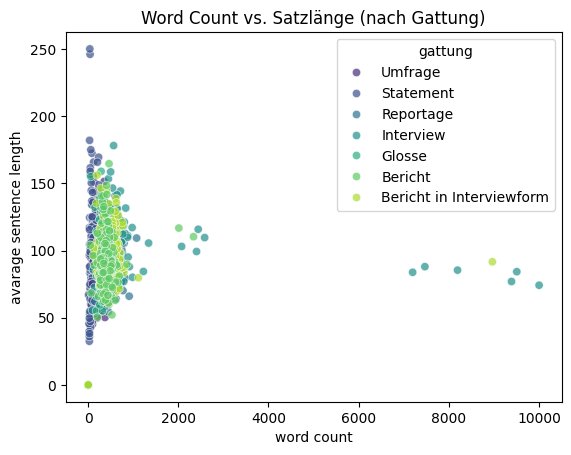

In [68]:
# Scatterplot mit Seaborn (handhabt Kategorien automatisch)
ax = sns.scatterplot(
    data=df,
    x='word_count',
    y='avr_sentence_length',
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)
ax.set(xlabel="word count", ylabel="avarage sentence length", title='Word Count vs. Satzlänge (nach Gattung)')

Hier gibt es einige üble Ausreißer bei der Anzahl der Wörter. Ich kürze die überlangen Texte auf den Durchschnitt der jeweiligen Gattung

In [89]:
df

,transcript,gattung,embedding,word_count,char_count,clean_text,avr_sentence_length,gattung_code,text_stopwordless
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,vor der letzten bundestagswahl waren sie absol...,73.73,6,letzten bundestagswahl waren absolut umfrageho...
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,he ute ist weltknuddeltag was es nicht alles g...,66.69,6,he ute weltknuddeltag alles gibt weltknuddelta...
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,47 elf grrrls wasser ja hat meine mutter immer...,59.18,6,47 elf grrrls wasser hat mutter immer gekauft ...
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,ja meint die atmosphäre im endeffekt gehört di...,77.11,6,meint atmosphäre endeffekt gehört leute allem ...
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,gestern abend großes familienfest vielleicht d...,67.77,6,gestern abend großes familienfest vielleicht i...
...,...,...,...,...,...,...,...,...,...
1356,"Da hüpft ein kleines Roboterbein im Kreis, es ...",Bericht,"0.046196766197681004, 0.041371896862983, -0.07...",276,1894,da hüpft ein kleines roboterbein im kreis es s...,93.75,0,hüpft kleines roboterbein kreis sieht känguru ...
1357,Noch ziemlich entspannt muss ich sagen ich kan...,Bericht,"0.050470415502786005, 0.022042037919163003, -0...",346,2194,noch ziemlich entspannt muss ich sagen ich kan...,90.46,0,noch ziemlich entspannt muss sagen glaube leug...
1358,"Seit der hier für die Rabattaktion Nein, bishe...",Bericht,"0.103638991713523, -0.041198708117008, -0.0684...",437,2638,seit der hier für die rabattaktion nein bisher...,66.67,0,seit hier rabattaktion bisherigen beschlüsse s...
1359,"Ich bin Leon Schäfer, 27 Jahre alt, Paar, Leic...",Bericht,"0.06876039505004801, -0.022558914497494, -0.06...",204,1251,ich bin leon schäfer 27 jahre alt paar leichta...,112.82,0,leon schäfer 27 jahre alt paar leichtathlet st...


In [98]:
def truncate_long_text(text, category):
    words = text.split(" ")
    if len(words) < 3000:
        return text
    else:
        return " ".join(words[:word_count_by_category[category].astype(int)])

df["transcript"] = df.apply(lambda row: truncate_long_text(row["transcript"],row["gattung"]), axis=1)

C:\Users\janfs\AppData\Local\Temp\ipykernel_17136\1058519101.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["transcript"] = df.apply(lambda row: truncate_long_text(row["transcript"],row["gattung"]), axis=1)


In [99]:
df["word_count"] = df["transcript"].apply(word_count)

C:\Users\janfs\AppData\Local\Temp\ipykernel_17136\1977437811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word_count"] = df["transcript"].apply(word_count)


[Text(0.5, 0, 'word count'),
 Text(0, 0.5, 'avarage sentence length'),
 Text(0.5, 1.0, 'Word Count vs. Satzlänge (nach Gattung)')]

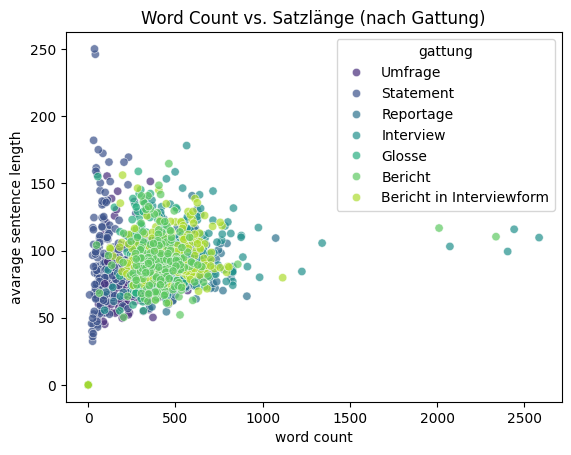

In [101]:
# Scatterplot mit Seaborn (handhabt Kategorien automatisch)
ax = sns.scatterplot(
    data=df,
    x='word_count',
    y='avr_sentence_length',
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)
ax.set(xlabel="word count", ylabel="avarage sentence length", title='Word Count vs. Satzlänge (nach Gattung)')

In [102]:
def clean(text):
    text = str(text).lower()
    text = re.sub("-"," ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

df["clean_text"] = df["transcript"].apply(clean)
df.loc[1]["clean_text"]

C:\Users\janfs\AppData\Local\Temp\ipykernel_17136\513554491.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_text"] = df["transcript"].apply(clean)


'he ute ist weltknuddeltag was es nicht alles gibt weltknuddeltag existiert schon seit 38 jahren und wurde ins leben gerufen und leuten vor augen zu führen wie wichtig so eine kurze umarmung so ein kurzes knuddeln fürs wohlbefinden sein kann unser reporter jens alenia hat nachgehakt und gefragt wann haben sie denn das letzte mal geknuddelt und wen mein mann meine freundin mein freund ist knüller mir von meiner oma mutter vater tante cousine großtante da kommt es ja aus dem knuddel nicht mehr raus das ist auch gut so meine freundin deren mann knuddel ist wie knuddeln den mann ihrer freunde ja natürlich wir sind uns sehr lange vertraute freunde ein bisschen körperkontakt muss schon sein auf jeden fall also schob ein teddybär den ich gern knuddele jeden abend eine bettdecke gibt es irgendeine bekannte persönlichkeit die sie ger ne mal knuddeln würden j taylor swift justin timberlake vielleicht denen würde ich knuddeln ja alle so süß ist ich glaub fremde leute knuddelt ich gar nicht so ger

In [104]:
stop_words = stopwords.get_stopwords("de")

def remove_stopwords(text):
    return " ".join([word for word in text.split(" ") if word not in stop_words])

df["text_stopwordless"] = df["clean_text"].apply(remove_stopwords)
df

C:\Users\janfs\AppData\Local\Temp\ipykernel_17136\1698058450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_stopwordless"] = df["clean_text"].apply(remove_stopwords)


,transcript,gattung,embedding,word_count,char_count,clean_text,avr_sentence_length,gattung_code,text_stopwordless,text_truncated
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,vor der letzten bundestagswahl waren sie absol...,73.73,6,letzten bundestagswahl waren absolut umfrageho...,Vor der letzten Bundestagswahl waren sie absol...
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,he ute ist weltknuddeltag was es nicht alles g...,66.69,6,he ute weltknuddeltag alles gibt weltknuddelta...,"He ute ist Weltknuddeltag, was es nicht alles ..."
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,47 elf grrrls wasser ja hat meine mutter immer...,59.18,6,47 elf grrrls wasser hat mutter immer gekauft ...,"47 elf, Grrrls Wasser ja, hat meine Mutter imm..."
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,ja meint die atmosphäre im endeffekt gehört di...,77.11,6,meint atmosphäre endeffekt gehört leute allem ...,"Ja, meint die Atmosphäre. Im Endeffekt gehört ..."
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,gestern abend großes familienfest vielleicht d...,67.77,6,gestern abend großes familienfest vielleicht i...,"Gestern Abend großes Familienfest, vielleicht ..."
...,...,...,...,...,...,...,...,...,...,...
1356,"Da hüpft ein kleines Roboterbein im Kreis, es ...",Bericht,"0.046196766197681004, 0.041371896862983, -0.07...",276,1894,da hüpft ein kleines roboterbein im kreis es s...,93.75,0,hüpft kleines roboterbein kreis sieht känguru ...,"Da hüpft ein kleines Roboterbein im Kreis, es ..."
1357,Noch ziemlich entspannt muss ich sagen ich kan...,Bericht,"0.050470415502786005, 0.022042037919163003, -0...",346,2194,noch ziemlich entspannt muss ich sagen ich kan...,90.46,0,noch ziemlich entspannt muss sagen glaube leug...,Noch ziemlich entspannt muss ich sagen ich kan...
1358,"Seit der hier für die Rabattaktion Nein, bishe...",Bericht,"0.103638991713523, -0.041198708117008, -0.0684...",437,2638,seit der hier für die rabattaktion nein bisher...,66.67,0,seit hier rabattaktion bisherigen beschlüsse s...,"Seit der hier für die Rabattaktion Nein, bishe..."
1359,"Ich bin Leon Schäfer, 27 Jahre alt, Paar, Leic...",Bericht,"0.06876039505004801, -0.022558914497494, -0.06...",204,1251,ich bin leon schäfer 27 jahre alt paar leichta...,112.82,0,leon schäfer 27 jahre alt paar leichtathlet st...,"Ich bin Leon Schäfer, 27 Jahre alt, Paar, Leic..."


In [47]:
nlp = spacy.load('de_core_news_md')

In [48]:
def tokenize(text):
    doc = nlp(text)
    tokens = [tok.text for tok in doc]
    return tokens

df["tokens"] = df["transcript"].progress_apply(tokenize)
df.head()

 18%|█▊        | 239/1360 [00:15<01:14, 14.97it/s]


KeyboardInterrupt: 

In [ ]:
def lemmatize(text):
     doc = nlp(text)
     return " ".join([x.lemma_ for x in doc])

df["text_lemmatized"] = df["text_stopwordless"].progress_apply(lemmatize)


  0%|          | 0/1360 [00:00<?, ?it/s]

100%|██████████| 1360/1360 [01:14<00:00, 18.31it/s]
C:\Users\janfs\AppData\Local\Temp\ipykernel_9284\1472405454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_lemmatized"] = df["text_stopwordless"].progress_apply(lemmatize)


In [ ]:
df.head()

,transcript,gattung,word_count,char_count,clean_text,text_stopwordless,tokens,text_lemmatized
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,262,1643,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...,"[Vor, der, letzten, Bundestagswahl, waren, sie...",letzter Bundestagswahl sein absolut Umfragehoc...
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,290,1759,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...,"[He, ute, ist, Weltknuddeltag, ,, was, es, nic...",he ute Weltknuddeltag alle geben Weltknuddelta...
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,222,1323,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...,"[47, elf, ,, Grrrls, Wasser, ja, ,, hat, meine...",47 elf grrrls Wasser haben Mutter immer kaufen...
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,115,702,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...,"[Ja, ,, meint, die, Atmosphäre, ., Im, Endeffe...",meinen Atmosphäre Endeffekt gehören leute alle...
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,333,2062,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...,"[Gestern, Abend, großes, Familienfest, ,, viel...",gestern abend groß Familienfest vielleicht ihn...


In [49]:
# load dataframe to save time
# try:
#     df.to_pickle("lemmatized.pkl")
# except:
#     df = pd.read_pickle("lemmatized.pkl")

df = pd.read_pickle("lemmatized.pkl")

In [ ]:
df["text_lemmatized"] = df["text_lemmatized"].str.lower()

C:\Users\janfs\AppData\Local\Temp\ipykernel_9284\1734597198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_lemmatized"] = df["text_lemmatized"].str.lower()


In [105]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=4000)

X = vectorizer.fit_transform(df["clean_text"])

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# PCA durchführen (auf 2D reduzieren)
svd = TruncatedSVD(n_components=2, random_state=42)
# pca = PCA(n_components=2)
X_pca = svd.fit_transform(X)  # X_count_vectorized = Ihre transformierten Daten

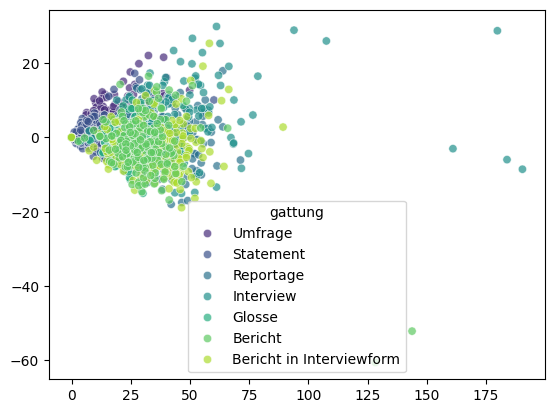

In [106]:
ax = sns.scatterplot(
    data=df,
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)

Was sind das hier für Ausreißer?

In [83]:
indices = np.where(X_pca[:,0] > 200)[0]
df.iloc[indices]

,transcript,gattung,embedding,word_count,char_count,clean_text,avr_sentence_length,gattung_code,text_stopwordless
602,"Ich habe eindeutig beobachtet, wie ich selber ...",Interview,"0.041198965162038005, -0.041934285312891006, -...",7469,45841,ich habe eindeutig beobachtet wie ich selber ü...,88.01,3,habe eindeutig beobachtet selber überall flach...
604,"Ich habe heimlich den Arzt angerufen, mit vers...",Interview,"0.07762149721384001, -0.043992321938276006, -0...",8193,48124,ich habe heimlich den arzt angerufen mit verst...,85.40,3,habe heimlich arzt angerufen verstellter stimm...
653,"Auf die Frage ja, und du bist Sängerin, habe i...",Interview,"0.023051939904689, -0.012720310129225, -0.0338...",7197,41805,auf die frage ja und du bist sängerin habe ich...,83.80,3,frage sängerin habe oft geantwortet andere sag...
666,"Wir haben Pläne geschmiedet, einen schönen Wei...",Interview,"0.010112901218235, -0.071924060583114, -0.0091...",9390,54171,wir haben pläne geschmiedet einen schönen wein...,76.95,3,haben pläne geschmiedet schönen wein getrunken...
676,"Ey, kann ich sagen mit 70 machen. Ich will doc...",Interview,"0.072779603302478, -0.008454346098005001, -0.0...",10002,57297,ey kann ich sagen mit 70 machen ich will doch ...,74.19,3,ey sagen 70 will fahrrad fahren um bisschen fi...
702,"Egal, wie schlimm es aussieht, solange man ges...",Interview,"0.105069823563098, -0.010321534238755, -0.0399...",9507,54045,egal wie schlimm es aussieht solange man gesun...,84.25,3,egal schlimm aussieht solange man gesund keine...
1080,Das muss man sich vorstellen. Der reichste Men...,Bericht in Interviewform,"0.09541089832782701, -0.030802305787801004, -0...",8966,55574,das muss man sich vorstellen der reichste mens...,91.62,1,muss man vorstellen reichste mensch welt kommt...


In [78]:
X_pca

array([[19.71765828, -7.26659079],
       [19.21199838,  1.43674863],
       [18.64449059, -0.37032351],
       ...,
       [34.56993581, -6.25549513],
       [11.98379076, -1.52533021],
       [13.53851529, -0.85582915]], shape=(1360, 2))

## Bag of Words

In [107]:
from sklearn.feature_extraction.text import CountVectorizer

### BoW + Naive Bayes

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [116]:
vectorizer = CountVectorizer(max_features=4000)

X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

Genauigkeit Trainingsset: 0.9163602941176471
Genauigkeit Testset: 0.4963235294117647


Overfitting!

### BoW + Logistic Regression

In [119]:
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(max_features=8000)
X = vectorizer.fit_transform(df["text_stopwordless"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='ovr', max_iter=10000)
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

C:\Users\janfs\Projekte\Python Projekte\2015 nlp-genres\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Genauigkeit Trainingsset: 0.9889705882352942
Genauigkeit Testset: 0.6139705882352942


Overfitting!

### BoW + Support Vector Machines

In [121]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

vectorizer = CountVectorizer(max_features=8000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

# model = SVC(kernel='linear', C=1.0)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Genauigkeit: {accuracy}")

Beste Parameter: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Bester Score: 0.6121080214500606


In [123]:
model = SVC(C=10, gamma="scale", kernel="rbf")
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

Genauigkeit Trainingsset: 0.9797794117647058
Genauigkeit Testset: 0.7095588235294118


Immer noch ein bisschen Overfitting, aber besser

### BoW + Decision Tree

In [126]:
from sklearn.tree import DecisionTreeClassifier

vectorizer = CountVectorizer(max_features=2000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", dt_classifier.score(X_train, y_train))
print("Genauigkeit Testset:", dt_classifier.score(X_test, y_test))

Accuracy: 0.40441176470588236
Genauigkeit Trainingsset: 0.9944852941176471
Genauigkeit Testset: 0.40441176470588236


Overfitting!

### BoW + Random Forest

In [127]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vorher: DecisionTreeClassifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Anzahl Bäume
    max_depth=None,     # Begrenzt Baumtiefe
    random_state=42,
    n_jobs=-1          # Nutzt alle CPU-Kerne
)
rf_classifier.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", rf_classifier.score(X_train, y_train))
print("Genauigkeit Testset:", rf_classifier.score(X_test, y_test))

Accuracy: 0.6176470588235294
Genauigkeit Trainingsset: 0.9944852941176471
Genauigkeit Testset: 0.6176470588235294


Overfitting!

In [97]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400]},
             verbose=1)

In [98]:
print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Beste Parameter: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}
Bester Score: 0.6148603057191706


## TF-IDF

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

### TF-IDF + Naive Bayes

In [103]:
# TF-IDF statt reinen Wortzählens
vectorizer = TfidfVectorizer(max_features=2000)  # 👈 Geändert
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Genauigkeit:", accuracy_score(y_test, y_pred))

Genauigkeit: 0.44485294117647056


### TF-IDF + Logistic Regreggion

In [113]:
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='ovr', max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit: {accuracy}")

Genauigkeit: 0.6507352941176471


### TF-IDF + SVM

In [116]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Beste Parameter: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Bester Score: 0.6525577218696255


### TF-IDF + Random Forest

In [117]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vorher: DecisionTreeClassifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Anzahl Bäume
    max_depth=None,     # Begrenzt Baumtiefe
    random_state=42,
    n_jobs=-1          # Nutzt alle CPU-Kerne
)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6176470588235294


In [118]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Beste Parameter: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 400}
Bester Score: 0.6240684088499258
